#Environment Setup

In [2]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Prepare Data

In [9]:
# Setting a fixed random seed for reproducibility
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Load datasets
made_shots = pd.read_csv('/content/drive/MyDrive/iot ballballs/made_shots.csv')
missed_shots = pd.read_csv('/content/drive/MyDrive/iot ballballs/missed_shots.csv')

# Add labels
made_shots['Label'] = 1
missed_shots['Label'] = 0

# Combine the datasets
data = pd.concat([made_shots, missed_shots], axis=0)

In [5]:
print(made_shots.shape)
print(missed_shots.shape)
print(data.shape)

(17600, 9)
(17600, 9)
(35200, 9)


In [6]:
def normalize_and_prepare_sequences(df):
    sequences = []
    labels = []

    for shot_id in df['ShotID'].unique():
        shot_data = df[df['ShotID'] == shot_id]

        # Normalize the IMU data
        normalized_sequence = (shot_data[['aX', 'aY', 'aZ', 'gX', 'gY', 'gZ']] + [4, 4, 4, 2000, 2000, 2000]) / [8, 8, 8, 4000, 4000, 4000]
        sequences.append(normalized_sequence.values)
        labels.append(shot_data['Label'].iloc[0])

    return sequences, labels

sequences, labels = normalize_and_prepare_sequences(data)

In [7]:
print(np.asarray(sequences, dtype="object").shape)
print(np.asarray(labels, dtype="object").shape)

(200, 176, 6)
(200,)


In [8]:
# Shuffle the sequences and labels together
sequences_shuffled, labels_shuffled = shuffle(sequences, labels, random_state=SEED)

# Pad sequences for consistent length
X = pad_sequences(sequences_shuffled, dtype='float32', padding='post')
print(X.shape)
y = to_categorical(labels_shuffled)
print(y.shape)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

(200, 176, 6)
(200, 2)


#Train Neural Network

##LSTM Single Layer

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Dropout

timesteps = 176
features = 6
output_units = 2

# Build the model
inputs = keras.Input(shape=(timesteps, features), batch_size=1)
x = keras.layers.LSTM(16)(inputs)
outputs = keras.layers.Dense(output_units, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='acc')

# Train the model
history = model.fit(X_train, y_train, epochs=400, validation_data=(X_test, y_test))

Epoch 1/400
5/5 [==============================] - 5s 320ms/step - loss: 0.6933 - acc: 0.4938 - val_loss: 0.6934 - val_acc: 0.4750
Epoch 2/400
5/5 [==============================] - 0s 85ms/step - loss: 0.6931 - acc: 0.5063 - val_loss: 0.6938 - val_acc: 0.4750
Epoch 3/400
5/5 [==============================] - 0s 92ms/step - loss: 0.6931 - acc: 0.5063 - val_loss: 0.6934 - val_acc: 0.4750
Epoch 4/400
5/5 [==============================] - 0s 61ms/step - loss: 0.6932 - acc: 0.5063 - val_loss: 0.6936 - val_acc: 0.4750
Epoch 5/400
5/5 [==============================] - 0s 51ms/step - loss: 0.6929 - acc: 0.5063 - val_loss: 0.6936 - val_acc: 0.4750
Epoch 6/400
5/5 [==============================] - 0s 49ms/step - loss: 0.6930 - acc: 0.5063 - val_loss: 0.6938 - val_acc: 0.4750
Epoch 7/400
5/5 [==============================] - 0s 47ms/step - loss: 0.6932 - acc: 0.5063 - val_loss: 0.6933 - val_acc: 0.4750
Epoch 8/400
5/5 [==============================] - 0s 48ms/step - loss: 0.6929 - acc: 0.5

##LSTM Double Layer

In [68]:
# Build the model
inputs = keras.Input(shape=(timesteps, features), batch_size=1)
x = LSTM(16, return_sequences=True)(inputs)
x = Dropout(0.3)(x)  # Dropout for regularization
x = LSTM(8, return_sequences=False)(x)
outputs = Dense(output_units, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

# Train the model
history = model.fit(X_train, y_train, epochs=400, validation_data=(X_test, y_test))

Epoch 1/400
5/5 [==============================] - 5s 334ms/step - loss: 0.6997 - acc: 0.5063 - val_loss: 0.7005 - val_acc: 0.4750
Epoch 2/400
5/5 [==============================] - 1s 127ms/step - loss: 0.6944 - acc: 0.5063 - val_loss: 0.6956 - val_acc: 0.4750
Epoch 3/400
5/5 [==============================] - 1s 186ms/step - loss: 0.6948 - acc: 0.4875 - val_loss: 0.6939 - val_acc: 0.5250
Epoch 4/400
5/5 [==============================] - 1s 187ms/step - loss: 0.6948 - acc: 0.4938 - val_loss: 0.6940 - val_acc: 0.5250
Epoch 5/400
5/5 [==============================] - 1s 169ms/step - loss: 0.6943 - acc: 0.4875 - val_loss: 0.6944 - val_acc: 0.3250
Epoch 6/400
5/5 [==============================] - 1s 185ms/step - loss: 0.6943 - acc: 0.4313 - val_loss: 0.6952 - val_acc: 0.4750
Epoch 7/400
5/5 [==============================] - 1s 148ms/step - loss: 0.6942 - acc: 0.5063 - val_loss: 0.6951 - val_acc: 0.4500
Epoch 8/400
5/5 [==============================] - 0s 102ms/step - loss: 0.6939 - a

##Conv1D Single Layer

In [17]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dense, Flatten
from tensorflow.keras.models import Sequential

timesteps = 176
features = 6
output_units = 2

# Build the model
model = Sequential([
    Input(shape=(timesteps, features), batch_size=1),
    Conv1D(filters=64, kernel_size=3, activation='relu'),

    MaxPooling1D(pool_size=2),  # Adding MaxPooling1D for reducing dimensionality
    Flatten(),  # Flatten the output to fit into Dense layer
    Dense(output_units, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test))


Epoch 1/200
5/5 [==============================] - 1s 73ms/step - loss: 0.7206 - accuracy: 0.4938 - val_loss: 0.6941 - val_accuracy: 0.5250
Epoch 2/200
5/5 [==============================] - 0s 20ms/step - loss: 0.6909 - accuracy: 0.5188 - val_loss: 0.6958 - val_accuracy: 0.4750
Epoch 3/200
5/5 [==============================] - 0s 20ms/step - loss: 0.6722 - accuracy: 0.5500 - val_loss: 0.6654 - val_accuracy: 0.6500
Epoch 4/200
5/5 [==============================] - 0s 21ms/step - loss: 0.6549 - accuracy: 0.7063 - val_loss: 0.6552 - val_accuracy: 0.7500
Epoch 5/200
5/5 [==============================] - 0s 17ms/step - loss: 0.6364 - accuracy: 0.7688 - val_loss: 0.6457 - val_accuracy: 0.6250
Epoch 6/200
5/5 [==============================] - 0s 20ms/step - loss: 0.6209 - accuracy: 0.6938 - val_loss: 0.6304 - val_accuracy: 0.7500
Epoch 7/200
5/5 [==============================] - 0s 21ms/step - loss: 0.6139 - accuracy: 0.7063 - val_loss: 0.6177 - val_accuracy: 0.7000
Epoch 8/200
5/5 [===

## Conv1D Double Layer

In [20]:
# Build the model
model = Sequential([
    Input(shape=(timesteps, features), batch_size=1),
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),

    MaxPooling1D(),
    Flatten(),
    Dense(output_units, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test))


Epoch 1/200
5/5 [==============================] - 1s 75ms/step - loss: 0.6986 - accuracy: 0.5125 - val_loss: 0.6857 - val_accuracy: 0.7000
Epoch 2/200
5/5 [==============================] - 0s 27ms/step - loss: 0.6876 - accuracy: 0.5750 - val_loss: 0.6840 - val_accuracy: 0.5750
Epoch 3/200
5/5 [==============================] - 0s 24ms/step - loss: 0.6817 - accuracy: 0.6250 - val_loss: 0.6775 - val_accuracy: 0.7500
Epoch 4/200
5/5 [==============================] - 0s 23ms/step - loss: 0.6773 - accuracy: 0.5750 - val_loss: 0.6745 - val_accuracy: 0.5750
Epoch 5/200
5/5 [==============================] - 0s 25ms/step - loss: 0.6659 - accuracy: 0.7000 - val_loss: 0.6679 - val_accuracy: 0.7250
Epoch 6/200
5/5 [==============================] - 0s 23ms/step - loss: 0.6568 - accuracy: 0.7063 - val_loss: 0.6617 - val_accuracy: 0.5250
Epoch 7/200
5/5 [==============================] - 0s 26ms/step - loss: 0.6484 - accuracy: 0.6625 - val_loss: 0.6479 - val_accuracy: 0.7250
Epoch 8/200
5/5 [===

#Verify

##Graph Loss Skipping Start

##Run with Test Data

2/2 [==============================] - 0s 7ms/step


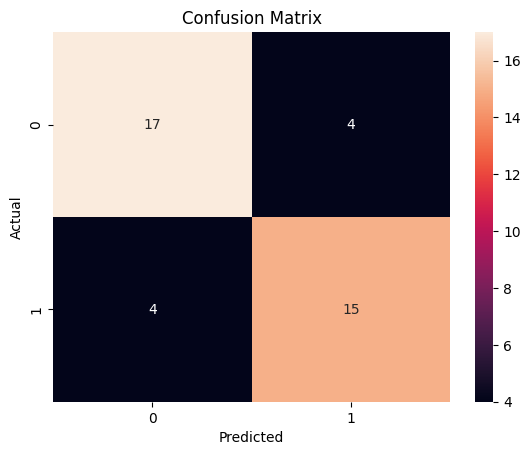

Model accuracy on the test dataset: 80.00%


In [21]:
# Use the model to predict the test inputs
predictions = model.predict(X_test)

# Convert probabilities to actual class predictions:
predicted_classes = np.argmax(predictions, axis=1)
# Convert one-hot encoded y_test to class labels
actual_classes = np.argmax(y_test, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(actual_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate the accuracy
accuracy = np.mean(predicted_classes == actual_classes)
print(f'Model accuracy on the test dataset: {accuracy * 100:.2f}%')

##Test on Whole Dataset

7/7 [==============================] - 0s 5ms/step


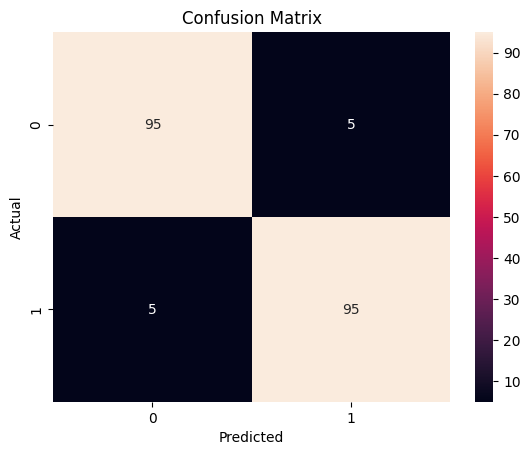

Model accuracy on the full dataset: 95.00%


In [22]:
# Predict on ALL DATA
predictions = model.predict(X)
predicted_classes = np.argmax(predictions, axis=1)
actual_classes = np.argmax(y, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(actual_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate the accuracy
accuracy = np.mean(predicted_classes == actual_classes)
print(f'Model accuracy on the full dataset: {accuracy * 100:.2f}%')

#Convert to TFLite

In [23]:
import tensorflow as tf

# Convert the model to TensorFlow Lite format for deployment
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Define a generator function that provides the test data.
def representative_dataset_gen():
    for i in range(len(X_test)):
        # Get sample input data as a numpy array
        yield [X_test[i:i+1].astype(np.float32)]

# Set the representative dataset for quantization.
converter.representative_dataset = representative_dataset_gen

# Convert the model
tflite_model = converter.convert()

# Save the model to a file
with open('shot_classification.tflite', 'wb') as f:
    f.write(tflite_model)


/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


##Test TFLite Model

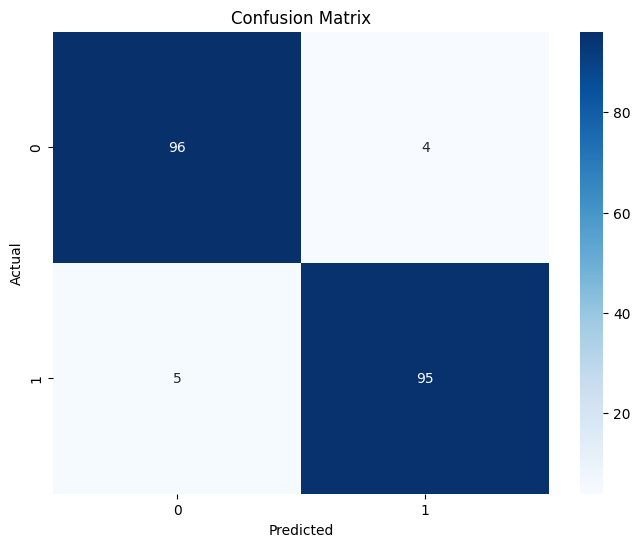

Model accuracy on the whole dataset: 95.50%


In [24]:
# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path="/content/shot_classification.tflite")
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

predicted_labels = []
actual_labels = []

# Loop through each item in X to make predictions
for i in range(len(X)):
    test_example = np.expand_dims(X[i], axis=0)  # Add batch dimension
    interpreter.set_tensor(input_details[0]['index'], test_example)
    interpreter.invoke()  # Run the model
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predicted_label = np.argmax(output_data)  # Get the predicted label
    predicted_labels.append(predicted_label)

    # Get the actual label from y
    actual_label = np.argmax(y[i])
    actual_labels.append(actual_label)

# Generate the confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate the accuracy
accuracy = np.mean(np.array(predicted_labels) == np.array(actual_labels))
print(f'Model accuracy on the whole dataset: {accuracy * 100:.2f}%')

##Encode to C

In [101]:
# function to convert some hex calue into an array for C program
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_H\n'
  c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += '#endif //' + var_name.upper() + '_H'

  return c_str

In [102]:
import os

# write TFLite model to C source file
with open("tflite_model.h", 'w') as file:
    file.write(hex_to_c_array(tflite_model, "tflite_model"))

# Get the size of the TFLite model in bytes.
model_size = os.path.getsize("tflite_model.h")
print(f'Model size: {model_size/1024} KB')

Model size: 118.8994140625 KB
